In [1]:
import tensorflow as tf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utils.layers import Sequential, Zip, Parallel, Linear, ScaleTanh
from utils.dynamics import Dynamics
from utils.func_utils import get_data, binarize, tf_accept
from utils.sampler import propose

In [2]:
path = 'logs/random_mask/optimizer=adam,learning_rate=0.001,latent_dim=50,MH=10,batch_size=512,update_sampler_every=1,leapfrogs=10/model.ckpt'
path = 'logs/09-27/optimizer=adam,learning_rate=0.001,latent_dim=50,MH=2,batch_size=512,update_sampler_every=1,leapfrogs=5,hmc=False/model.ckpt'
with tf.gfile.Open(path+'.meta'):
    tf.reset_default_graph()
    tf.train.import_meta_graph(path+'.meta')

In [3]:
mask = tf.get_default_graph().get_tensor_by_name('sampler/Const_%d:0' % 1)

with tf.Session() as sess:
    mask = sess.run(mask)

In [4]:
tf.reset_default_graph()

In [ ]:
node_list = [(n.name, n) for n in tf.get_default_graph().as_graph_def().node if 'Const' in str(n.name)]

In [84]:
print 'kernel?'

kernel?


In [ ]:
mask

In [5]:
with tf.variable_scope('encoder'):
    encoder = Sequential([
        Linear(784, 1024, scope='encoder_1'),
        tf.nn.softplus,
        Linear(1024, 1024, scope='encoder_2'),
        tf.nn.softplus,
        Parallel([
            Linear(1024, 50, scope='encoder_mean'),
            Linear(1024, 50, scope='encoder_std'),
        ])
    ])

with tf.variable_scope('decoder'):
    decoder = Sequential([
        Linear(50, 1024, scope='decoder_1'),
        tf.nn.softplus,
        Linear(1024, 1024, scope='decoder_2'),
        tf.nn.softplus,
        Linear(1024, 784, scope='decoder_3', factor=0.01)
    ])

# Setting up the VAE

inp = tf.placeholder(tf.float32, shape=(None, 784))

mu, log_sigma = encoder(inp)

noise = tf.random_normal(tf.shape(mu))

latent_q = mu + noise * tf.exp(log_sigma)

logits = decoder(latent_q)

# Setting up sampler
def energy(z, aux=None):
    logits = decoder(z)
    log_posterior = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=aux, logits=logits), axis=1)
    log_prior = -0.5 * tf.reduce_sum(tf.square(z), axis=1)
    return -log_posterior - log_prior

sampler_loss = 0.

with tf.variable_scope('sampler'):
    size1 = 200
    size2 = 200

    encoder_sampler = Sequential([
        Linear(784, 512, scope='encoder_1'),
        tf.nn.softplus,
        Linear(512, 512, scope='encoder_2'),
        tf.nn.softplus,
        Linear(512, size1, scope='encoder_3'),
    ])

    def net_factory(x_dim, scope, factor):
        with tf.variable_scope(scope):
            net = Sequential([
                Zip([
                    Linear(50, size1, scope='embed_1', factor=0.33),
                    Linear(50, size1, scope='embed_2', factor=factor * 0.33),
                    Linear(2, size1, scope='embed_3', factor=0.33),
                    encoder_sampler,
                ]),
                sum,
                tf.nn.relu,
                Linear(size1, size2, scope='linear_1'),
                tf.nn.relu,
                Parallel([
                    Sequential([
                        Linear(size2, 50, scope='linear_s', factor=0.01), 
                        ScaleTanh(50, scope='scale_s')
                    ]),
                    Linear(size2, 50, scope='linear_t', factor=0.01),
                    Sequential([
                        Linear(size2, 50, scope='linear_f', factor=0.01),
                        ScaleTanh(50, scope='scale_f'),
                    ])
                ])
            ])
        return net

    dynamics = Dynamics(
        50, 
        energy, 
        T=5, 
        eps=0.1, 
        hmc=False, 
        net_factory=net_factory, 
        eps_trainable=True, 
        use_temperature=False,
    )

In [6]:
dynamics.mask = tf.constant(mask, tf.float32)

In [21]:
x = tf.placeholder(tf.float32, shape=(None, 784))
z_start = tf.placeholder(tf.float32, shape=(None, 50))
_, _, _, MH = propose(z_start, dynamics, do_mh_step=True, aux=inp)
probs = tf.nn.sigmoid(decoder(MH[0]))
sample = tf.cast((probs - tf.random_uniform(tf.shape(probs)) >= 0), tf.float32)

In [ ]:
Z = tf.placeholder(tf.float32, shape=(None, 50))
probs = tf.nn.sigmoid(decoder(Z))
sample = tf.cast((probs - tf.random_uniform(tf.shape(probs)) >= 0), tf.float32)

In [7]:
saver = tf.train.Saver()

sess = tf.Session()

In [8]:
saver.restore(save_path=path, sess=sess)

INFO:tensorflow:Restoring parameters from logs/09-27/optimizer=adam,learning_rate=0.001,latent_dim=50,MH=2,batch_size=512,update_sampler_every=1,leapfrogs=5,hmc=False/model.ckpt


In [10]:
train, test = get_data()
x_train = binarize(train)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [18]:
x0 = x_train[66]
x0 = np.reshape(x0, (28, 28))
x0[:14, :] = 0
x0 = x0.flatten()[None, :]
x0.shape

(1, 784)

In [20]:
init_chain = sess.run(latent_q, {inp: x0})

In [ ]:
for eps in np.arange(0.05, 0.125, 0.025):
    hmc_dynamics = Dynamics(
        50, 
        energy, 
        T=10, 
        eps=eps, 
        hmc=True, 
    )
    z_start_hmc = tf.placeholder(tf.float32, shape=(None, 50))
    _, _, _, MH_HMC = propose(z_start_hmc, hmc_dynamics, do_mh_step=True, aux=inp)
    hmc_samples = []
    samples = np.copy(init_chain)
    for t in range(2000):
        hmc_samples.append(np.copy(samples))
        samples = sess.run(MH_HMC[0], {inp: x_0, z_start_hmc: samples})
    G = np.array(hmc_samples[1000:])
    print G.shape
    plt.plot(np.abs([autocovariance(G - mu, tau=t) for t in range(199)]), label='$\epsilon=%.2f$' % eps)
plt.plot(np.abs([autocovariance(F[1000:, :, :] - mu, tau=t) for t in range(199)]), label='CS')
plt.xlabel('# MH steps')
plt.ylabel('Autocovariance')
plt.legend()

In [ ]:
for t in range(50):
    plt.hist(F[1000:, :, t].flatten(), bins=100, alpha=0.1)
    plt.hist(G[:, :, t].flatten(), bins=100, alpha=0.1, color='red')
    plt.show()

In [ ]:
F[:, :, t].flatten().shape

In [ ]:
list_samples2 = []



In [ ]:
list_samples = []

samples = np.copy(init_chain)
for t in range(2000):
    list_samples.append(np.copy(samples))
    samples = sess.run(MH[0], {inp: x_0, z_start: samples})

In [ ]:
def autocovariance(X, tau=0):
    dT, dN, dX = np.shape(X)
    s = 0.
    for t in range(dT - tau):
        x1 = X[t, :, :]
        x2 = X[t+tau, :, :]

        s += np.sum(x1 * x2) / dN

    return s / (dT - tau)

In [ ]:
F = np.array(list_samples)
mu = F[1000:, :, :].mean(axis=(0, 1))

In [ ]:
G = np.array(list_samples2)

In [ ]:
#plt.plot(np.abs([autocovariance(G - mu, tau=t) for t in range(199)]))
plt.plot(np.abs([autocovariance(F[1000:, :, :] - mu, tau=t) for t in range(199)]))
plt.xlim(0, 60)

In [33]:
z_eval = tf.random_normal((64, 50))
x_eval = tf.nn.sigmoid(decoder(z_eval))

In [38]:
def plot_grid(S, width=8):
    sheet_width = width
    plt.figure(figsize=(12, 12))
    for i in xrange(S.shape[0]):
        plt.subplot(sheet_width, sheet_width, i + 1)
        plt.imshow(S[i], cmap='gray')
        plt.grid('off')
        plt.axis('off')

In [ ]:
train, test = get_data()

In [ ]:
train = np.reshape(train, (-1, 28, 28))

In [ ]:
mask

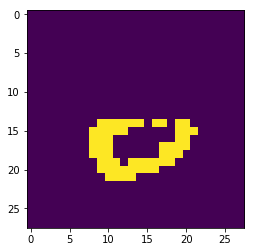

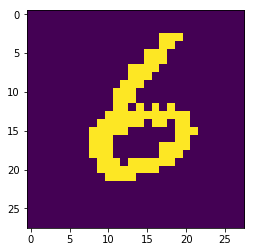

In [15]:
x0 = np.copy(x_train[66])
x0 = binarize(x0)
X0 = np.reshape(x0, (28, 28))
plt.imshow(X0)

# samples2 = []
# curr_sample = np.copy(x0).flatten()[None, :]
# for t in range(100):
#     current_z = sess.run(latent, {inp: curr_sample})
#     # curr_sample = sess.run(sample, {Z: current_z})
#     curr_probs = sess.run(probs, {Z: current_z})
#     samples2.append(np.copy(curr_probs))

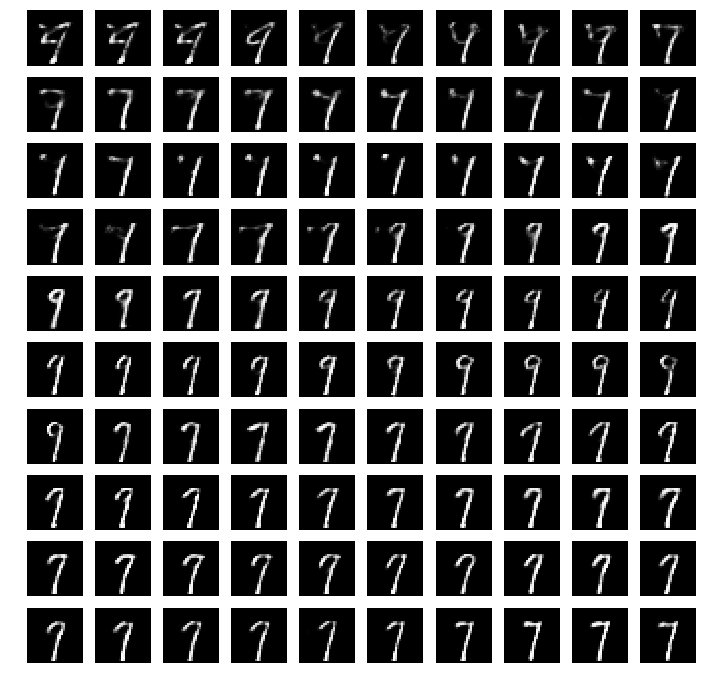

In [83]:
S = np.array(samples)
S = np.reshape(S, (-1, 28, 28))

plot_grid(S, width=10)

In [82]:
samples = []
x0 = viz[42]
x0[:14, :] = 0
x0 = x0.flatten()[None, :]
curr_x = np.copy(x0)
curr_z = np.copy(init_chain)

x0_2 = np.reshape(x0, (28, 28))
for t in range(100):
    curr_z, candidate_x, curr_probs = sess.run([MH[0], sample, probs], {inp: curr_x, z_start: curr_z})
    samples.append(np.copy(curr_probs))
    curr_x = np.reshape(candidate_x, (28, 28))
    curr_x[14:, :] = x0_2[14:, :]
    curr_x = curr_x.flatten()[None, :]

In [51]:
x0_old = np.copy(x0)

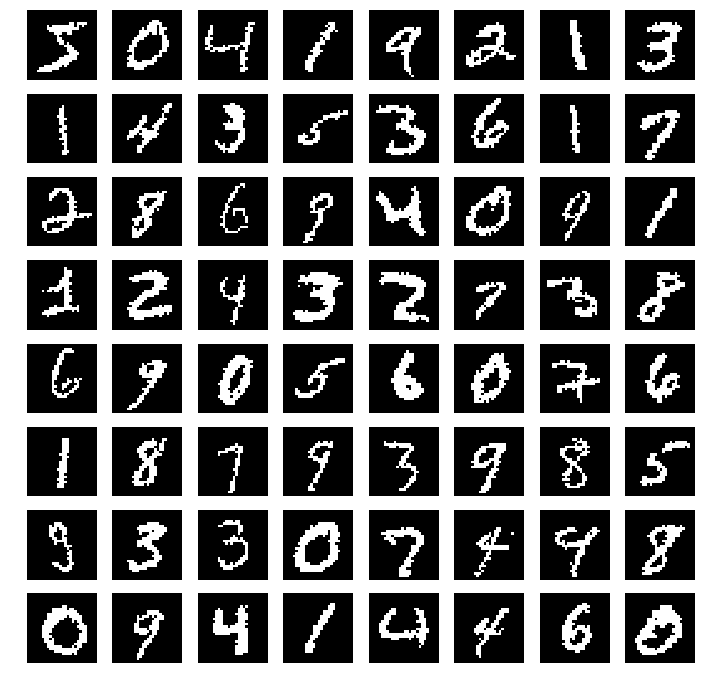

In [66]:
plot_grid(viz[:64])

In [65]:
viz = np.reshape(x_train, (-1, 28, 28))

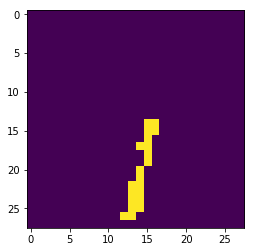

In [81]:
plt.imshow(mask(viz[42]))

In [74]:
def mask(x):
    y = np.copy(x)
    y[:14, :] = 0
    return y